# LSTM - Time Serise Dataset

* 서울시 기후 데이터 : 2011년 01월 01일 ~ 2019년 12월 31일
* https://data.kma.go.kr/cmmn/main.do
* 기후통계분석 -> 기온분석 -> 기간(20110101~20191231) -> 검색 -> CSV 다운로드
* Seoul_Temp.csv

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Import Packages

* Packages

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# 1. Colab File Upload

> ## 1) 'Seoul_Temp.csv' 파일을 Colab에 업로드 후 진행

In [3]:
url = 'https://raw.githubusercontent.com/rusita-ai/pyData/master/Seoul_Temp.csv'
temp = pd.read_csv(url)

temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3287 non-null   object 
 1   avg     3287 non-null   float64
 2   min     3287 non-null   float64
 3   max     3287 non-null   float64
dtypes: float64(3), object(1)
memory usage: 102.8+ KB


In [4]:
temp.head()

,date,avg,min,max
0,2011-01-01,-6.8,-10.4,-2.9
1,2011-01-02,-5.4,-8.5,-1.2
2,2011-01-03,-4.5,-8.5,-0.3
3,2011-01-04,-3.9,-7.4,-1.7
4,2011-01-05,-4.0,-7.7,-1.8


In [5]:
temp.tail()

,date,avg,min,max
3282,2019-12-27,-1.7,-4.6,2.6
3283,2019-12-28,1.1,-3.6,6.1
3284,2019-12-29,3.8,1.1,6.2
3285,2019-12-30,2.7,-5.7,6.8
3286,2019-12-31,-7.9,-10.9,-4.5


# 2. Data Preprocessing

> ## 1) 일일 평균온도('avg') 변화 시각화

* 일일 평균온도 변화에 일정한 패턴 확인

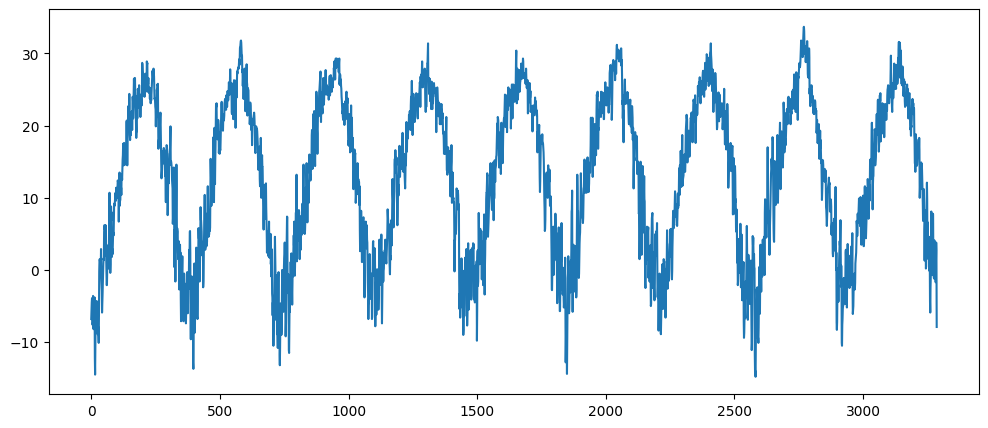

In [6]:
temp_data = temp[['avg']]

plt.figure(figsize = (12, 5))
plt.plot(temp_data)
plt.show()

> ## 2) Normalization

* tanh Activation 적용을 위해 -1 ~ 1 범위로 정규화

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))

temp_data = scaler.fit_transform(temp_data)

> ## 3) Train vs. Test Split
- 시간의 순서가 중요하므로 random split하면 안됨(싸이킷런 함수)
* Train_Dataset : 2011년 01월 01일 ~ 2017년 12월 31일
* Test_Dataset : 2018년 01월 01일 ~ 2019년 12월 31일

In [8]:
train = temp_data[0:2557]
test  = temp_data[2557:]

In [9]:
train

array([[-0.67010309],
       [-0.61237113],
       [-0.57525773],
       ...,
       [-0.30309278],
       [-0.33195876],
       [-0.40206186]])

# 3. 시계열 데이터 처리 함수

> ## 1) 시계열 학습용 데이터 생성 함수 정의

* X : 학습 평균온도 데이터
* y : 정답 평균온도 데이터
* 일정 기간의 X로 y를 예측하도록 학습
* 예를 들어, look_back이 2일 때, time_data가 [1, 2, 3, 4, 5]라면, data_X는 [[1, 2], [2, 3], [3, 4]]가 되고, data_y는 [3, 4, 5]가 됩니다.

In [10]:
def create_dataset(time_data, look_back = 1):
    data_X, data_y = [], []

    for i in range(len(time_data) - look_back):
        data_X.append(time_data[i:(i + look_back), 0])
        data_y.append(time_data[i + look_back, 0])

    return np.array(data_X), np.array(data_y)

> ## 2) loop_back 기간 설정 후 학습데이터 생성

* 180일 기간 평균온도로 다음날 평균온도 예측 데이터 생성

In [11]:
look_back = 180

train_X, train_y = create_dataset(train, look_back)
test_X,  test_y  = create_dataset(test, look_back)

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2377, 180), (2377,), (550, 180), (550,))

In [12]:
train_X

array([[-0.67010309, -0.61237113, -0.57525773, ...,  0.40206186,
         0.60412371,  0.47628866],
       [-0.61237113, -0.57525773, -0.55051546, ...,  0.60412371,
         0.47628866,  0.59175258],
       [-0.57525773, -0.55051546, -0.55463918, ...,  0.47628866,
         0.59175258,  0.64536082],
       ...,
       [ 0.61237113,  0.62886598,  0.71134021, ..., -0.54639175,
        -0.6742268 , -0.47628866],
       [ 0.62886598,  0.71134021,  0.74020619, ..., -0.6742268 ,
        -0.47628866, -0.30309278],
       [ 0.71134021,  0.74020619,  0.74845361, ..., -0.47628866,
        -0.30309278, -0.33195876]])

In [13]:
train_y

array([ 0.59175258,  0.64536082,  0.62886598, ..., -0.30309278,
       -0.33195876, -0.40206186])

> ## 3) Tensor Reshape

In [14]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2377, 180, 1), (2377,), (550, 180, 1), (550,))

# 4. LSTM

> ## 1) Model Define

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential(name = 'LSTM')
model.add(LSTM(128,
               input_shape = (None, 1)))

model.add(Dense(1, activation = 'tanh'))

* Model Summary

In [16]:
model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66689 (260.50 KB)
Trainable params: 66689 (260.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


> ## 2) Model Compile

In [17]:
model.compile(loss = 'mse',
              optimizer = 'adam',
              metrics = ['mae'])

> ## 3) Model Fit

* 약 6분

In [18]:
%%time

hist = model.fit(train_X, train_y,
                 epochs = 100,
                 batch_size = 16,
                 validation_data = (test_X, test_y))

Epoch 1/100
149/149 [==============================] - 11s 27ms/step - loss: 0.0210 - mae: 0.1089 - val_loss: 0.0197 - val_mae: 0.1118
Epoch 2/100
149/149 [==============================] - 4s 24ms/step - loss: 0.0144 - mae: 0.0917 - val_loss: 0.0120 - val_mae: 0.0847
Epoch 3/100
149/149 [==============================] - 3s 18ms/step - loss: 0.0123 - mae: 0.0841 - val_loss: 0.0105 - val_mae: 0.0772
Epoch 4/100
149/149 [==============================] - 3s 22ms/step - loss: 0.0111 - mae: 0.0805 - val_loss: 0.0102 - val_mae: 0.0772
Epoch 5/100
149/149 [==============================] - 2s 13ms/step - loss: 0.0103 - mae: 0.0772 - val_loss: 0.0092 - val_mae: 0.0746
Epoch 6/100
149/149 [==============================] - 2s 10ms/step - loss: 0.0098 - mae: 0.0752 - val_loss: 0.0088 - val_mae: 0.0730
Epoch 7/100
149/149 [==============================] - 1s 10ms/step - loss: 0.0094 - mae: 0.0735 - val_loss: 0.0082 - val_mae: 0.0692
Epoch 8/100
149/149 [==============================] - 1s 10m

> ## 4) 학습결과 시각화

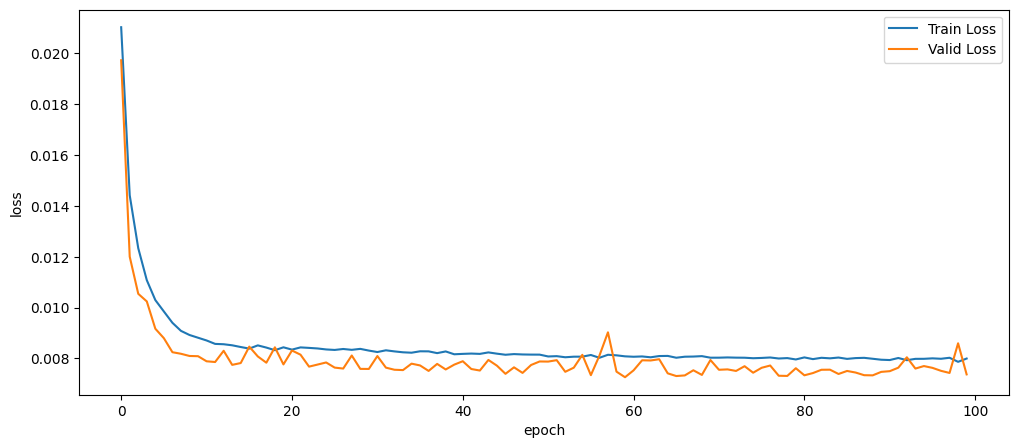

In [19]:
plt.figure(figsize = (12, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()

> ## 5) Model Evaluate

In [20]:
trainScore = model.evaluate(train_X, train_y, verbose = 0)
print('Train Score: ', trainScore)

testScore = model.evaluate(test_X, test_y, verbose = 0)
print('Test Score: ', testScore)

Train Score:  [0.007765896152704954, 0.06592345982789993]
Test Score:  [0.007371590472757816, 0.06539533287286758]


## 6) Model Predict

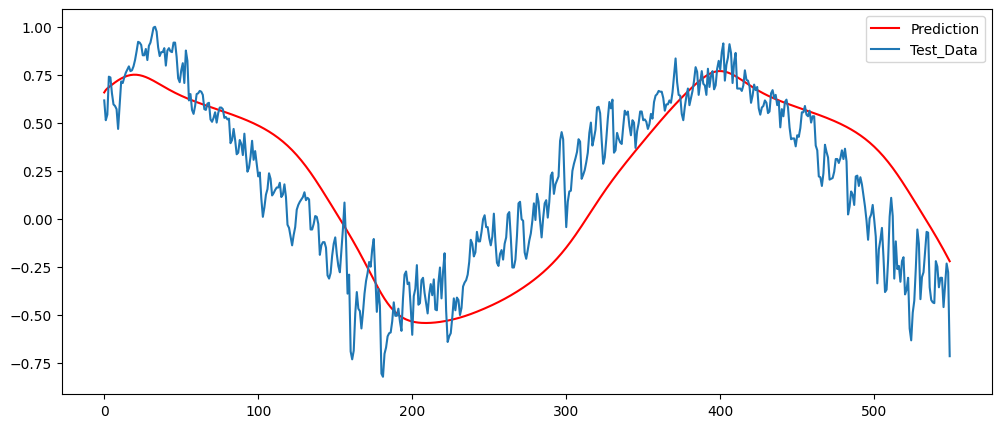

In [21]:
look_ahead = 550

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size = 1, verbose = 0)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])

plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')
plt.legend()
plt.show()

# 5. Stacked LSTM Modeling

> ## 1) Model Define

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model2 = Sequential(name = 'Stackd_LSTM')
model2.add(LSTM(64,
               input_shape = (None, 1),
               return_sequences = True))
model2.add(LSTM(64,
               input_shape = (None, 1),
               return_sequences = False))
model2.add(Dense(1, activation = 'tanh'))

* Model Summary

In [23]:
model2.summary()

Model: "Stackd_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, None, 64)          16896     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49985 (195.25 KB)
Trainable params: 49985 (195.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


> ## 2) Model Compile

In [24]:
model2.compile(loss = 'mse',
              optimizer = 'adam',
              metrics = ['mae'])

> ## 3) Model Fit

* 약 10분

In [25]:
%%time

hist2 = model2.fit(train_X, train_y,
                 epochs = 100,
                 batch_size = 16,
                 validation_data = (test_X, test_y))

Epoch 1/100
149/149 [==============================] - 6s 21ms/step - loss: 0.0262 - mae: 0.1191 - val_loss: 0.0177 - val_mae: 0.1045
Epoch 2/100
149/149 [==============================] - 2s 16ms/step - loss: 0.0180 - mae: 0.1029 - val_loss: 0.0155 - val_mae: 0.0986
Epoch 3/100
149/149 [==============================] - 3s 20ms/step - loss: 0.0165 - mae: 0.0996 - val_loss: 0.0139 - val_mae: 0.0923
Epoch 4/100
149/149 [==============================] - 2s 16ms/step - loss: 0.0153 - mae: 0.0950 - val_loss: 0.0151 - val_mae: 0.0977
Epoch 5/100
149/149 [==============================] - 2s 16ms/step - loss: 0.0141 - mae: 0.0910 - val_loss: 0.0142 - val_mae: 0.0925
Epoch 6/100
149/149 [==============================] - 3s 19ms/step - loss: 0.0130 - mae: 0.0880 - val_loss: 0.0123 - val_mae: 0.0852
Epoch 7/100
149/149 [==============================] - 3s 20ms/step - loss: 0.0122 - mae: 0.0843 - val_loss: 0.0102 - val_mae: 0.0783
Epoch 8/100
149/149 [==============================] - 3s 17ms

> ## 4) 학습결과 시각화

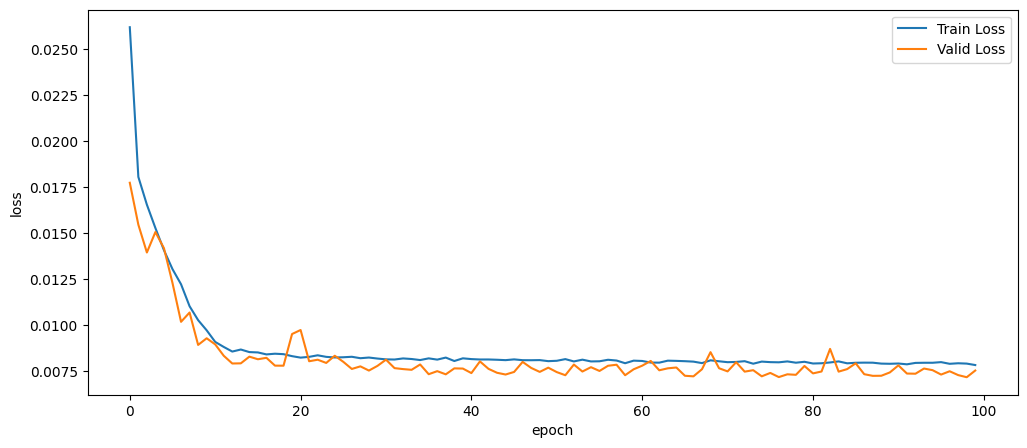

In [26]:
plt.figure(figsize = (12, 5))
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()

> ## 5) Model Evaluate

In [27]:
trainScore = model2.evaluate(train_X, train_y, verbose = 0)
print('Train Score: ', trainScore)

testScore = model2.evaluate(test_X, test_y, verbose = 0)
print('Test Score: ', testScore)

Train Score:  [0.007967359386384487, 0.06521724909543991]
Test Score:  [0.007540363818407059, 0.06493322551250458]


## 6) Model Predict

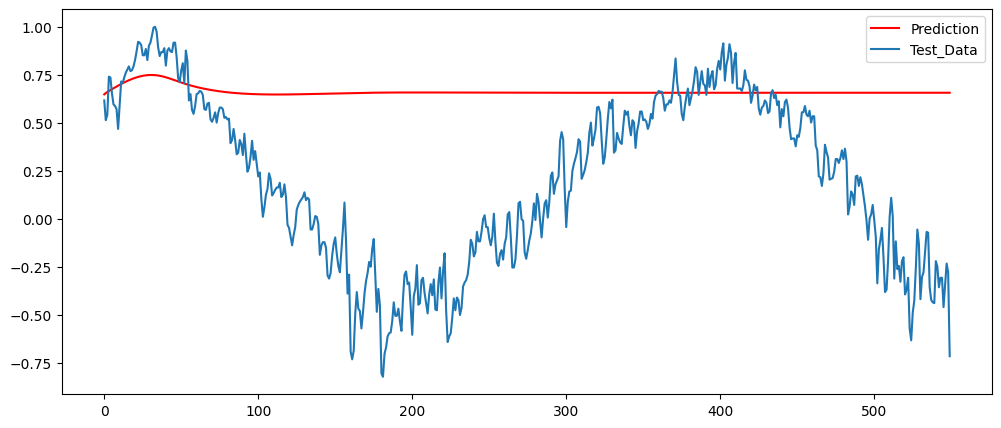

In [28]:
look_ahead = 550

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model2.predict(np.array([xhat]), batch_size = 1, verbose = 0)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])

plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')
plt.legend()
plt.show()

# 6. Gated Recurrent Unit

> ## 1) Model Define

In [29]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU

model3 = Sequential(name = 'GRU')
model3.add(GRU(64, input_shape = (None, 1)))
model3.add(Dense(1, activation = 'tanh'))

* Model Summary

In [30]:
model3.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12929 (50.50 KB)
Trainable params: 12929 (50.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


> ## 2) Model Compile

In [31]:
model3.compile(loss = 'mse',
              optimizer = 'adam',
              metrics = ['mae'])

> ## 3) Model Fit

* 약 10분

In [32]:
%%time

hist3 = model3.fit(train_X, train_y,
                 epochs = 100,
                 batch_size = 16,
                 validation_data = (test_X, test_y))

Epoch 1/100
149/149 [==============================] - 4s 13ms/step - loss: 0.0240 - mae: 0.1132 - val_loss: 0.0134 - val_mae: 0.0904
Epoch 2/100
149/149 [==============================] - 1s 10ms/step - loss: 0.0130 - mae: 0.0874 - val_loss: 0.0113 - val_mae: 0.0832
Epoch 3/100
149/149 [==============================] - 1s 9ms/step - loss: 0.0113 - mae: 0.0810 - val_loss: 0.0108 - val_mae: 0.0775
Epoch 4/100
149/149 [==============================] - 1s 9ms/step - loss: 0.0104 - mae: 0.0775 - val_loss: 0.0092 - val_mae: 0.0729
Epoch 5/100
149/149 [==============================] - 1s 9ms/step - loss: 0.0096 - mae: 0.0746 - val_loss: 0.0091 - val_mae: 0.0745
Epoch 6/100
149/149 [==============================] - 1s 9ms/step - loss: 0.0093 - mae: 0.0732 - val_loss: 0.0084 - val_mae: 0.0697
Epoch 7/100
149/149 [==============================] - 2s 13ms/step - loss: 0.0091 - mae: 0.0719 - val_loss: 0.0087 - val_mae: 0.0699
Epoch 8/100
149/149 [==============================] - 1s 10ms/ste

> ## 4) 학습결과 시각화

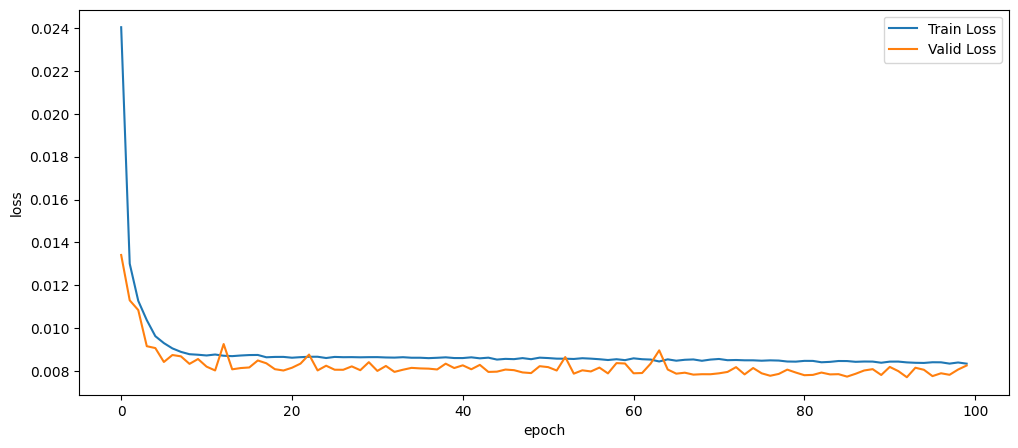

In [33]:
plt.figure(figsize = (12, 5))
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()

> ## 5) Model Evaluate

In [34]:
trainScore = model3.evaluate(train_X, train_y, verbose = 0)
print('Train Score: ', trainScore)

testScore = model3.evaluate(test_X, test_y, verbose = 0)
print('Test Score: ', testScore)

Train Score:  [0.008819114416837692, 0.06797908991575241]
Test Score:  [0.008259959518909454, 0.06712503731250763]


## 6) Model Predict

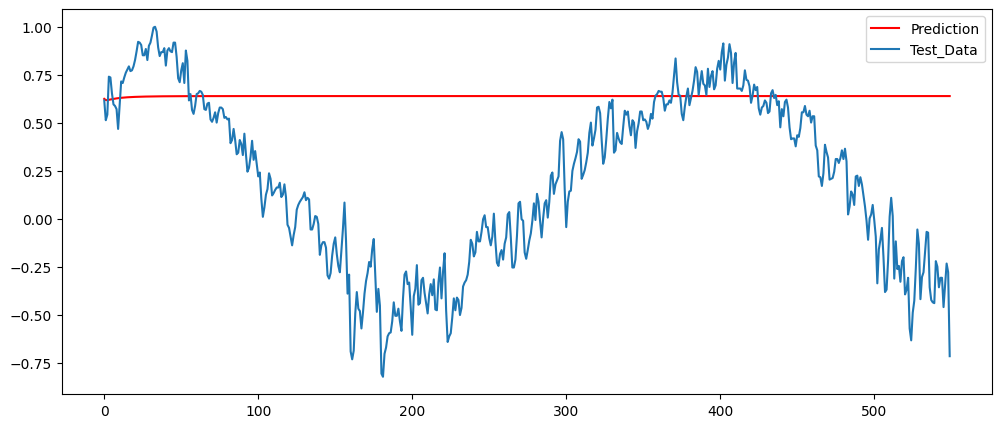

In [35]:
look_ahead = 550

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model3.predict(np.array([xhat]), batch_size = 1, verbose = 0)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])

plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')
plt.legend()
plt.show()

# 7. Bidirectional LSTM Modeling

> ## 1) Model Define

In [36]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional

model4 = Sequential(name = 'Bidirectional_LSTM')
model4.add(Bidirectional(LSTM(64,
                             input_shape = (None, 1))))
model4.add(Dense(1, activation = 'tanh'))

* Model Summary

In [37]:
# model4.summary() error

> ## 2) Model Compile

In [38]:
model4.compile(loss = 'mse',
              optimizer = 'adam',
              metrics = ['mae'])

> ## 3) Model Fit

* 약 10분

In [39]:
%%time

hist4 = model4.fit(train_X, train_y,
                 epochs = 100,
                 batch_size = 16,
                 validation_data = (test_X, test_y))

Epoch 1/100
149/149 [==============================] - 8s 27ms/step - loss: 0.0205 - mae: 0.1072 - val_loss: 0.0147 - val_mae: 0.0956
Epoch 2/100
149/149 [==============================] - 3s 18ms/step - loss: 0.0146 - mae: 0.0922 - val_loss: 0.0153 - val_mae: 0.1009
Epoch 3/100
149/149 [==============================] - 2s 16ms/step - loss: 0.0130 - mae: 0.0875 - val_loss: 0.0111 - val_mae: 0.0802
Epoch 4/100
149/149 [==============================] - 3s 20ms/step - loss: 0.0119 - mae: 0.0834 - val_loss: 0.0114 - val_mae: 0.0844
Epoch 5/100
149/149 [==============================] - 2s 16ms/step - loss: 0.0110 - mae: 0.0801 - val_loss: 0.0104 - val_mae: 0.0782
Epoch 6/100
149/149 [==============================] - 2s 15ms/step - loss: 0.0102 - mae: 0.0771 - val_loss: 0.0098 - val_mae: 0.0763
Epoch 7/100
149/149 [==============================] - 2s 15ms/step - loss: 0.0097 - mae: 0.0753 - val_loss: 0.0088 - val_mae: 0.0718
Epoch 8/100
149/149 [==============================] - 2s 16ms

> ## 4) 학습결과 시각화

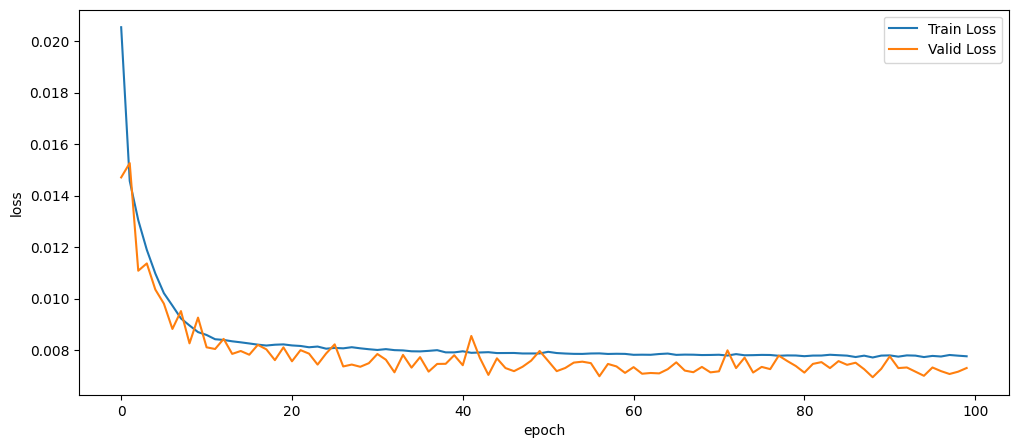

In [40]:
plt.figure(figsize = (12, 5))
plt.plot(hist4.history['loss'])
plt.plot(hist4.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()

> ## 5) Model Evaluate

In [41]:
trainScore = model4.evaluate(train_X, train_y, verbose = 0)
print('Train Score: ', trainScore)

testScore = model4.evaluate(test_X, test_y, verbose = 0)
print('Test Score: ', testScore)

Train Score:  [0.007765231188386679, 0.06690365076065063]
Test Score:  [0.0073060765862464905, 0.06476271152496338]


## 6) Model Predict

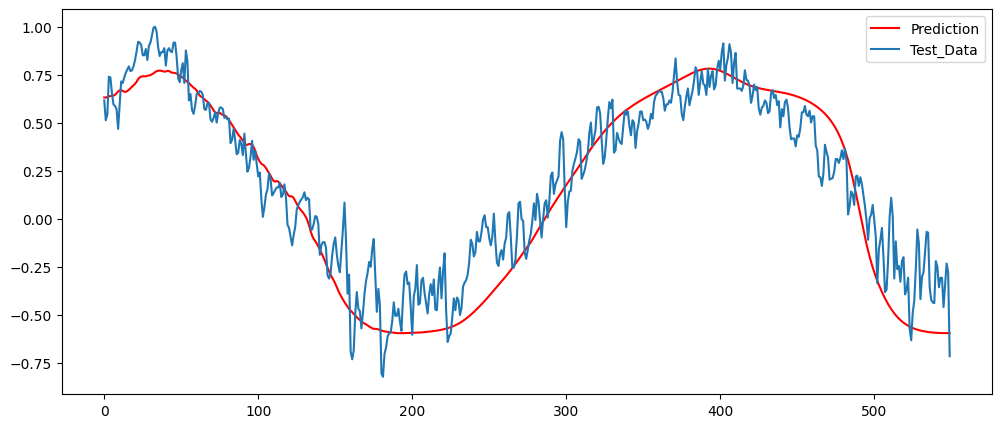

In [42]:
look_ahead = 550

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model4.predict(np.array([xhat]), batch_size = 1, verbose = 0)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])

plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')
plt.legend()
plt.show()

# The End